<a href="https://colab.research.google.com/github/melissamelton/BachelorAnalysis/blob/main/TheBachelorAnalysis_GSB521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Bachelor Analysis Version 2- *How Demographic Variables Play a Role in Contestant Success & Predictors of Relationship Length***


*By Melissa Melton (mnmelton@calpoly.edu) & Annika Bertelsen (abertels@calpoly.edu)*

March 9, 2023

**Brief Background**: A single bachelor (or bachelorette) dates a group of approximately 30 women (or men) over several weeks, narrowing the group of contestants down week by week after a series of one-on-one or group dates to hopefully find true love.

**Goal of Analysis:** Gather historical data of all participating contestants from past seasons, to be able to identify any trends within contestant demographics.
Focusing on the Winner of each season, as well as contestants who made it to the Top Four, we will utilize demographics of age, occupation, and home state to examine how much each variable contributes to contestants' success likelihood.  

We also aim to examine how predictors such as number of one-on-one dates or recieving the first impression role might have an impact on relationship length.

**Hypothesis:** One of our driving questions was which variables, if any, from contestant demographics will be the most important in determining how far the contestant makes it to the end? Here, we hypothesize that Age will be the most significant predictor for the Bachelor, while Occupation will be the most significant for the Bachelorette. This hypothesis is rooted in sterotypes that men may tend to go for the younger woman while women may put high value on suitors' occupations.   

Our driving question for part 2 of our analysis was if there a significant difference between the proportion of couples from the Bachelor versus Bachelorette who last at least one year? That is- do the men Bachelor's or women Bachelorette's make better decisions when selecting their partner out of the group of 30 contestants? Here we hypothesize that womans intuition will lead them to pick a best suited partner, meaning the Bachelorette will have longer relationship lengths on average.

In [1]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.image as  image
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy import distance
from scipy.stats import pearsonr
from statsmodels.stats.proportion import proportions_ztest

# The Bachelor Data Gathering & Cleaning

We will start by gathering data on contestants from the Bachelor.

## Scraping

Obtain a list of the seasons we can scrape data from on Wikipedia:

In [2]:
# The Bachelor has had 26 seasons so far (27 is currently airing so it will not be included)
seasons = np.arange(1, 27, 1)
# seasons 3, 4, and 6-8 do not have contestant data on Wikipedia
missing_table = {3, 4, 6, 7, 8}
# obtain list of season numbers which have contestant data on their wiki page
seasons = [x for x in seasons if x not in missing_table]

We will now use the BeautifulSoup library to scrape data about contestants from Wikipedia.

In [3]:
contestants_df = pd.DataFrame()
urlstart = "https://en.wikipedia.org/wiki/The_Bachelor_(American_season_"

def seasons_scrape(seasons, contestants_df, urlstart):
  # loop through seasons
  for i in range(0, len(seasons)):
    # write the url for specific season
    wikiurl = urlstart + str(seasons[i]) + ")"
    table_class = "wikitable sortable jquery-tablesorter"
    response = requests.get(wikiurl)
    # parse data from html
    soup = BeautifulSoup(response.text, 'html.parser')
    contestant_table = soup.find('table', {'class':"wikitable"})
    df = pd.read_html(str(contestant_table))
    # convert list to dataframe
    df = pd.DataFrame(df[0])
    # add column for the season (value the same for all rows from that season)
    df['Season'] = seasons[i]
    # seasons 1 and 2 have a different label for the Outcome and Occupation columns
    if 'Eliminated' in df.columns and 'Job' in df.columns:
      df.rename(columns = {'Eliminated': 'Outcome',
                           'Job': 'Occupation'}, inplace = True)
    # keep only desired columns
    df = df[['Season', 'Name', 'Age', 'Hometown', 'Occupation', 'Outcome']]
    contestants_df = contestants_df.append(df, ignore_index = True)
  return contestants_df


In [4]:
contestants_df = seasons_scrape(seasons, contestants_df, urlstart)

Unfortunately, full contestant data cannot be found online for seasons 3, 4, 6, 7, and 8 (even the Bachelor Nation fandom Wiki does not have it). So, our resulting dataframe only represents 21 of the 26 full seasons.

## Cleaning

Perform clean-up on the contestants_df dataframe.

In [5]:
# sometimes contestants will leave one week then return a later week. Remove the
# rows from the table which reference them leaving (the info we care about is stored
# in another row, including their final placement)
contestants_df[contestants_df['Age'] == "(Returned to competition)"]

# remove these rows -- the data for these contestants is still in the table, just a different row
contestants_df = contestants_df[contestants_df['Age'] != "(Returned to competition)"]

In [6]:
# some contestants' names had hyperlinks. Remove the references attached
contestants_df['Name'] = contestants_df['Name'].apply(lambda x: x.split('[')[0]
                                                      if '[' in x else x)
# separate town and state into their own columns
contestants_df[['Town', 'State']] = contestants_df.Hometown.str.split(',', expand = True)
# make sure age is numeric
contestants_df['Age'] = pd.to_numeric(contestants_df['Age'])

# keep desired columns
cols = ['Season', 'Name', 'Age', 'Town', 'State', 'Occupation', 'Outcome']
contestants_df = contestants_df[cols]

In [7]:
contestants_df

,Season,Name,Age,Town,State,Occupation,Outcome
0,1,Amanda Marsh,23.0,Chanute,Kansas,Event Planner,Winner
1,1,Trista Rehn,29.0,St. Louis,Missouri,Miami Heat Dancer,Runner-up
2,1,Shannon Oliver,24.0,Dallas,Texas,Financial Management Consultant,Week 5
3,1,Kim,24.0,Tempe,Arizona,Nanny,Week 4
4,1,Cathy Grimes,22.0,Terre Haute,Indiana,Graduate Student,Week 3
...,...,...,...,...,...,...,...
578,26,Jane Paik,33.0,Santa Monica,California,Social Media Director,Week 1
579,26,Lindsay Dobbs,27.0,Warner Robins,Georgia,Neonatal Nurse,Week 1
580,26,Rianna Hockaday,26.0,Mount Pleasant,Texas,Registered Nurse,Week 1
581,26,Samantha Jeffries,26.0,Dayton,Ohio,Occupational Therapist,Week 1


Create a new data frame representing all winners of the show. Note: Season 11 notoriously does not have a winner--that season's bachelor Brad Womack infamously broke up with both his final two women!

Create another new data frame with the top four contestants from each season.

In [8]:
# winners
winners_df = contestants_df[contestants_df['Outcome'] == "Winner"]

# top 4
top4_df = contestants_df.groupby('Season').head(4)

## Occupation Categorization 
The contestant occupations are specific to the individual. To better analyze trends in popular occupations, we will create a dictionary to categorize contestants' jobs. We created this dictionary based on common themes identified in the jobs of contestants in the top 4 of each season.

In [9]:
# set up key words we will use for detecting occupation categories
marketing = ['Marketing', 'Content', 'Publicist', 'Communications', 'Social Media', 'Advertising']
sales = ['Sales', 'Salesperson', 'Account Executive']
finance = ['Finance', 'Financial']
managmentconsult = ['Consultant', 'Business', 'Buyer', 'Executive Assistant',
                    'Recruiter', 'Administrative']
teacher = ['Teacher']
student = ['Student']
medical = ['Nurse', 'Hospital', 'Chiropractic', 'Phlebotomist']
dance = ['Dancer', 'Dance Instructor', 'Cheerleader']
therapy = ['Psychologist', 'Therapist', 'Speech Pathologist']
dental = ['Dental']
realestate = ['Real Estate', 'Realtor']
attorney = ['Attorney']
flight = ['Flight']
arts = ['Graphic Designer', 'Creative Director', 'Photographer', 'Videographer', 'Actress', 'Designer']
beauty = ['Stylist', 'Hairstylist', 'Esthetician', 'Fashion', 'Cosmetics', 'Clothier']
events = ['Event Planner', 'Bridal', 'Funeral Director']
model = ['Model']
construction = ['Contractor']
socialwork = ['Social Worker']

# create a dictionary of job categories, with the values representing the list of jobs within the key
job_dictionary1 = {'Marketing': marketing, 'Sales': sales, 'Teaching': teacher, 
                   'Finance': finance, 'Management and Consulting': managmentconsult,
                  'Medical': medical, 'Dance': dance, 'Therapy': therapy,
                  'Dental Care': dental, 'Real Estate': realestate, 'Legal': attorney, 
                  'Flight': flight, 'Arts': arts, 'Beauty': beauty, 
                  'Events': events, 'Modeling': model, 'Student': student,
                   'Construction': construction, 'Social Work': socialwork}

This function will look at the occupation of each contestant in a data frame and then look through each key, value pair in the provided job dictionary. If the contestant's occupation matches a job in one of the keys, the name of that key will be inputted as their job category. If the contestant's job does not appear in the dictionary, the category will be designated as "Not Found".

Note: we are only running this function for the top 4 and winners dataframes since these contestants' jobs were the ones used in designing the dictionary. We are primarily interested in comparing the job categories for the women who were "successful" on the show.

In [10]:
def calculateJobCategory(row):
  occupation = row['Occupation'].casefold()

  for k, v in job_dictionary1.items():
    for occupation_keywords in v:
      if occupation_keywords.casefold() in occupation:
        return k

  #print(f"did not find {occupation}")
  return "not found"

top4_df['Job Category'] = top4_df.apply(calculateJobCategory, axis=1)
winners_df['Job Category'] = winners_df.apply(calculateJobCategory, axis=1)

# counts of each job category among all Bachelorette contestants who made top 4
top4_df['Job Category'].value_counts()

<ipython-input-10-d7b5bab1e4a1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top4_df['Job Category'] = top4_df.apply(calculateJobCategory, axis=1)
<ipython-input-10-d7b5bab1e4a1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners_df['Job Category'] = winners_df.apply(calculateJobCategory, axis=1)


Arts                         9
Marketing                    9
Management and Consulting    7
Medical                      7
Sales                        6
Beauty                       6
Teaching                     6
not found                    5
Modeling                     4
Real Estate                  4
Therapy                      3
Student                      3
Dance                        3
Flight                       3
Dental Care                  2
Events                       2
Legal                        2
Social Work                  1
Construction                 1
Finance                      1
Name: Job Category, dtype: int64

In [11]:
#new Job Category df with percentages for TOP4 and WINNERS- women on Bachelor
norm_job_4 = top4_df['Job Category'].value_counts()
norm_job_4 = norm_job_4.reset_index(name='count')
norm_job_4['percentage'] = norm_job_4['count']/norm_job_4['count'].sum()

norm_job_win = winners_df['Job Category'].value_counts()
norm_job_win = norm_job_win.reset_index(name='count')
norm_job_win['percentage'] = norm_job_win['count']/norm_job_win['count'].sum()

# The Bachelorette Data Gathering & Cleaning

Now we will perform the same process, but for contestants on the Bachelorette, where a female lead dates a group of male suitors.

## Scraping

Once again, we create an array representing the seasons we can obtain data from on Wikipedia. Thankfully this time, all seasons have contestant data available.

In [12]:
# The Bachelorette has had 19 seasons so far
seasons = np.arange(1, 20, 1)

Use the BeautifulSoup library to create a data frame containing information on all Bachelorette contestants, using the seasons_scrape() function from the prior section.

In [13]:
# create new contestant data frame for Bachelorette
contestants_df2 = pd.DataFrame()
urlstart = "https://en.wikipedia.org/wiki/The_Bachelorette_(American_season_"

# call seasons_scrape() function
contestants_df2 = seasons_scrape(seasons, contestants_df2, urlstart)

## Cleaning

Perform some clean-up on the contestants dataframe:

In [14]:
# sometimes contestants will leave one week then return a later week. Remove the
# rows from the table which reference them leaving (the info we care about is stored
# in another row, including their final placement)
contestants_df2[contestants_df2['Age'] == "(Returned to competition)"]

# remove these rows -- the data for these contestants is still in the table, just a different row
contestants_df2 = contestants_df2[contestants_df2['Age'] != "(Returned to competition)"]

contestants_df2 = contestants_df2.dropna(axis=0)

In [15]:
# some contestants' names had hyperlinks. Remove the references attached
contestants_df2['Name'] = contestants_df2['Name'].apply(lambda x: x.split('[')[0] if '[' in x else x)
# fix some unclean age values
contestants_df2['Age'] = contestants_df2['Age'].apply(str).apply(lambda x: x.split('[')[0] if '[' in x else x)
# separate town and state into their own columns
contestants_df2[['Town', 'State']] = contestants_df2['Hometown'].str.split(',', expand = True)
# make sure age is numeric
contestants_df2['Age'] = pd.to_numeric(contestants_df2['Age'])

# keep desired columns
cols = ['Season', 'Name', 'Age', 'Town', 'State', 'Occupation', 'Outcome']
contestants_df2 = contestants_df2[cols]

<ipython-input-15-db3357fb9832>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contestants_df2['Name'] = contestants_df2['Name'].apply(lambda x: x.split('[')[0] if '[' in x else x)
<ipython-input-15-db3357fb9832>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contestants_df2['Age'] = contestants_df2['Age'].apply(str).apply(lambda x: x.split('[')[0] if '[' in x else x)
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [16]:
contestants_df2

,Season,Name,Age,Town,State,Occupation,Outcome
0,1,Ryan Sutter,28,Vail,Colorado,Firefighter,Winner
1,1,Charlie Maher,28,Hermosa Beach,California,Financial Analyst,Runner-up
2,1,Russell Woods,31,San Rafael,California,Writer,Week 5
3,1,Greg Todtman,28,Manhattan,New York,Importer,Week 4
4,1,Bob Guiney,31,Ferndale,Michigan,Mortgage Broker,Week 3
...,...,...,...,...,...,...,...
525,19,Chris Austin,30,Redondo Beach,California,Mentality Coach,Week 2
526,19,Jordan Vandergriff,27,Alpharetta,Georgia,Drag Racer,Week 2
527,19,Joey Young,24,Brookfield,Connecticut,Twin,Week 1
528,19,Justin Young,24,Brookfield,Connecticut,Other Twin,Week 1


Create two new data frames for the winners and top 4 of each season. It should be noted that two Bachelorette seasons are rather special--seasons 16 and 19 both had two different Bachelorettes, so they will each have two winners!

In [17]:
# winners
winners_df2 = contestants_df2[contestants_df2['Outcome'] == "Winner"]

# top 4
top4_df2 = contestants_df2.groupby('Season').head(4)

## Occupation Categorization

We will create a different jobs dictionary, since the male contestants tend to have different jobs from the female contestants. Like we did with the female contestants, we observed common trends among the top 4 contestants from each season to create this dictionary.

In [18]:
# set up key words we will use for detecting occupation categories
marketing = ['Marketing', 'Content', 'Publicist', 'Communications', 'Social Media']
finance = ['Banker', 'Portfolio', 'Equity', 'Financial', 'Investment']
sales = ['Sales', 'Salesperson', 'Salesman', 'Insurance Agent']
managementconsult = ['Consultant', 'Business', 'Buyer', 'Entrepreneur', 
                     'Wine', 'Restaurant', 'Startup', 'Account Executive', 'Tech Executive',
                     'Retail Manager']
teacher = ['Teacher']
student = ['Student']
medical = ['Nurse', 'Hospital', 'Chiropractor', 'Medicine']
sports = ['Snowboarder', 'Football', 'Quarterback', 'Swimmer',' Trainer', 'Race', 
          'Baseball', 'Basketball', 'Personal Trainer']
therapy = ['Psychologist', 'Therapist', 'Speech Pathologist', 'Addiction Specialist']
dental = ['Dental']
arts = ['Singer', 'Photographer', 'Writer', 'Musician', 'Art']
realestate = ['Real Estate', 'Realtor', 'Mortgage']
attorney = ['Attorney']
flight = ['Flight', 'Pilot']
engineer = ['Engineer']
armyvet = ['Army', 'Veteran']
construction = ['General Contractor', 'Construction', 'Landscaper']

# create a dictionary of job categories, with the values representing the list of jobs within the key
job_dictionary2 = {'Marketing': marketing, 'Finance': finance, 'Sales': sales, 'Teaching': teacher, 'Management and Consulting': managementconsult,
                  'Medical': medical, 'Sports': sports, 'Arts': arts, 'Therapy': therapy,
                  'Dental Care': dental, 'Real Estate': realestate, 'Legal': attorney, 
                  'Flight': flight, 'Engineering': engineer, 
                  'Army or Veteran': armyvet, 'Student': student, 'Construction': construction}

In [19]:
def calculateJobCategory(row):
  occupation = row['Occupation'].casefold()

  for k, v in job_dictionary2.items():
    for occupation_keywords in v:
      if occupation_keywords.casefold() in occupation:
        return k

  #print(f"did not find {occupation}")
  return "not found"

top4_df2['Job Category'] = top4_df2.apply(calculateJobCategory, axis=1)
winners_df2['Job Category'] = winners_df2.apply(calculateJobCategory, axis=1)

# counts of each job category among all Bachelorette contestants who made top 4
top4_df2['Job Category'].value_counts()

<ipython-input-19-1ecf9a92a34f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top4_df2['Job Category'] = top4_df2.apply(calculateJobCategory, axis=1)
<ipython-input-19-1ecf9a92a34f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners_df2['Job Category'] = winners_df2.apply(calculateJobCategory, axis=1)


Sales                        16
Management and Consulting    14
Sports                       10
not found                     6
Finance                       5
Real Estate                   5
Arts                          4
Construction                  4
Medical                       3
Marketing                     2
Engineering                   2
Army or Veteran               2
Teaching                      1
Flight                        1
Therapy                       1
Name: Job Category, dtype: int64

Normalize the categories and get the percent of contestants each makes up.

In [20]:
#new Job Category df with percentages for TOP4 and WINNERS- men on Bachelor
norm_job_4_2 = top4_df2['Job Category'].value_counts()
norm_job_4_2 = norm_job_4_2.reset_index(name='count')
norm_job_4_2['percentage'] = norm_job_4_2['count']/norm_job_4_2['count'].sum()

norm_job_win2 = winners_df2['Job Category'].value_counts()
norm_job_win2 = norm_job_win2.reset_index(name='count')
norm_job_win2['percentage'] = norm_job_win2['count']/norm_job_win2['count'].sum()

In [21]:
norm_job_4_2.head()

,index,count,percentage
0,Sales,16,0.210526
1,Management and Consulting,14,0.184211
2,Sports,10,0.131579
3,not found,6,0.078947
4,Finance,5,0.065789


# Visualization of Contestant Demographics

## Contestants by Age

To start our investigation into contestants' age, we will first show boxplots of all contestant ages by season for both franchises.

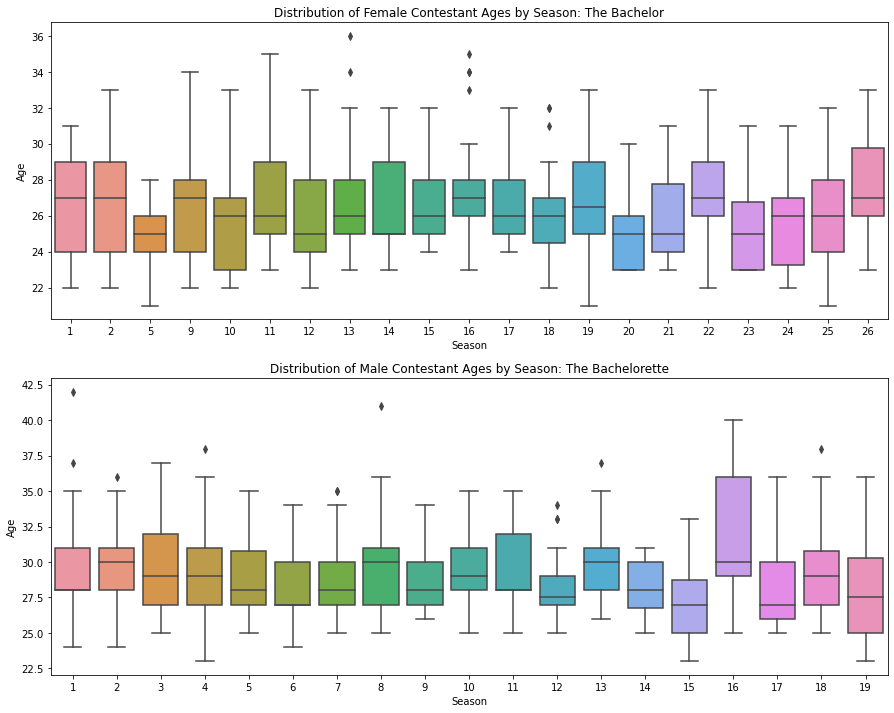

In [22]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(15, 12))

#distribution of ALL Contestant ages by season: Bachelor
sns.boxplot(x='Season', y='Age', data = contestants_df, ax=ax[0])
ax[0].set_title("Distribution of Female Contestant Ages by Season: The Bachelor")

#distribution of ALL Contestant ages by season: Bachelorette
sns.boxplot(x='Season', y='Age', data = contestants_df2, ax=ax[1])
ax[1].set_title("Distribution of Male Contestant Ages by Season: The Bachelorette") 
# show the graph
plt.show()

**Overall (all Contestants, all Seasons) mean ages were as follows:**  

Female Mean Age: 26.3 years old 

Male Mean Age: 29.1 years old 


Now, we will examine how the distribution of contestant ages for all seasons on the Bachelor varies Overall, among the Top 4 contestants, and among the Winners.

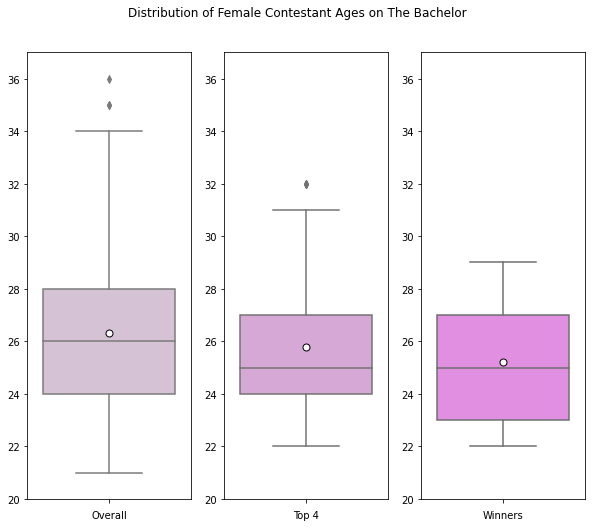

In [23]:
df_list = [contestants_df, top4_df, winners_df]
df_names = ['Overall', 'Top 4', 'Winners']
colors = ['thistle', 'plum', 'violet']
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,8))

for c in range(3):
  sns.boxplot(y='Age', data = df_list[c], ax=axes[c], color=colors[c], 
              showmeans = True, meanprops = {'marker': 'o',
                                             'markerfacecolor': 'white',
                                             'markeredgecolor': 'black',
                                             'markersize': 7})
  axes[c].set(ylabel='', xlabel=df_names[c])
  axes[c].set_ylim(20,37)
  axes[c].set_facecolor

fig.subplots_adjust(top=0.9)
fig.suptitle("Distribution of Female Contestant Ages on The Bachelor")
plt.show()

The boxplot demonstrates that the mean age Overall (all contestants) is slightly over 26, but for the Top 4 and the Winners, it slightly decreases to 25, with the Winners having the lowest mean age. We see that the variability in age also decreases from Overall to Top 4 to Winners. No woman over 29 has won the show before. This supports our hypothesis that the Bachelors tend to favor younger women, with ages 23-27 being the most popular.

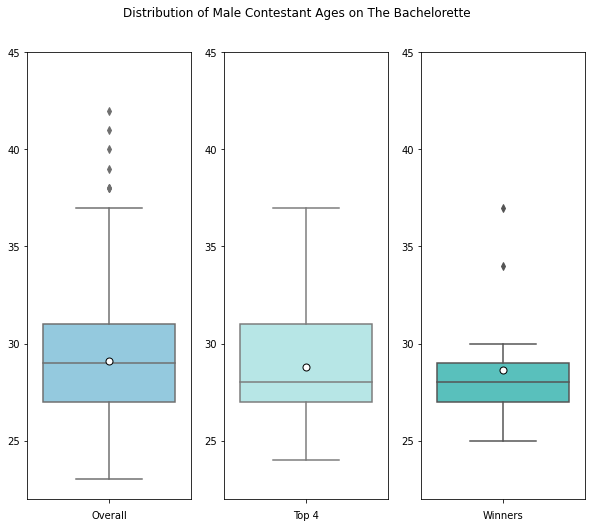

In [24]:
df_list = [contestants_df2, top4_df2, winners_df2]
df_names = ['Overall', 'Top 4', 'Winners']
colors = ['skyblue', 'paleturquoise', 'mediumturquoise']
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10,8))

for c in range(3):
  sns.boxplot(y='Age', data = df_list[c], ax=axes[c], color=colors[c], 
              showmeans = True, meanprops = {'marker': 'o',
                                             'markerfacecolor': 'white',
                                             'markeredgecolor': 'black',
                                             'markersize': 7})
  axes[c].set(ylabel='', xlabel=df_names[c])
  axes[c].set_ylim(22, 45)
  axes[c].set_facecolor

fig.subplots_adjust(top=0.9)
fig.suptitle("Distribution of Male Contestant Ages on The Bachelorette")
plt.show()

The mean age of male contestants looks to be around 28 years old for all subgroups- Overall, Top 4, and Winners. The distributions of the Overall and Top 4 groups are quite similar, except for a few outliers in the Overall grouping. For Winners, the IQR is much smaller. The majority of Winners are between ages 27-29. This narrow range of low age values is smaller than we expected; we expected more of the men who won to be in their early thirties. 

We had expected age to be a factor the Bachelors used to narrow down their top choices among the women, but the Bachelorettes seem to also be quite selective in their age preference of men!

## Contestants by Occupation

To determine the most common occupations among Winners or contestants who place in the Top 4, we will use a barplot, including the 7 most popular job categories.

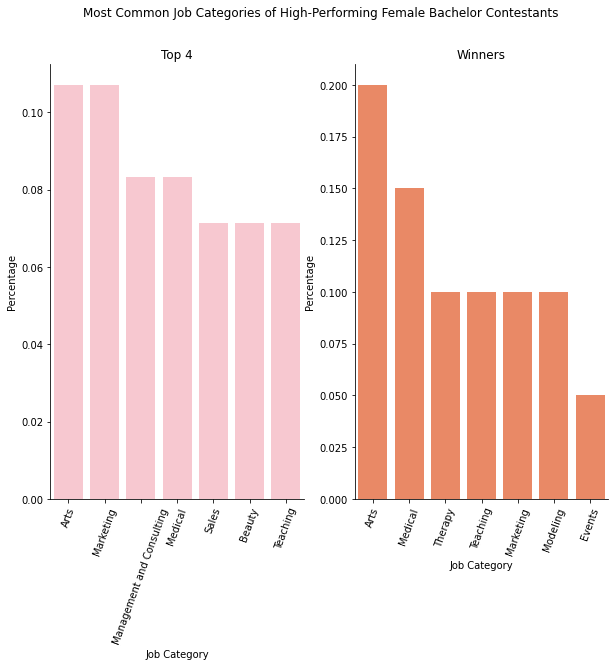

In [25]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,8))

order_top4 = norm_job_4['index'].iloc[:7]
order_winners = norm_job_win["index"].iloc[:7]

# value on the y axis will be the percentage of contestants from the category, instead of the count
sns.barplot(x = norm_job_4["index"], y = norm_job_4["percentage"], color="pink", ax = axes[0],
              order=order_top4).set(title="Top 4")
axes[0].set_xticklabels(order_top4, rotation = 70)
axes[0].set_xlabel('Job Category')
axes[0].set_ylabel('Percentage')

sns.barplot(x = norm_job_win["index"], y = norm_job_win["percentage"], color="coral", ax = axes[1],
              order=order_winners).set(title="Winners")
axes[1].set_xticklabels(order_winners, rotation = 70)
axes[1].set_xlabel('Job Category')
axes[1].set_ylabel('Percentage')

fig.suptitle('Most Common Job Categories of High-Performing Female Bachelor Contestants')
sns.despine()

For the Top 4 subgroup, there was 84 women total. For the Winners, there were 20 women. This histogram plots the popularity of the job in comparision to the entire group.
Arts and Medicine are the leading job categories for female Winners, with categories Therapy, Teaching, Marketing, and Modeling all tied. 
Arts, marketing, teaching, and medicine are common among both the Top 4 and just Winners. Arts and Marketing are the most common field among contestants who made Top 4. We would expect marketing to be a common occupation for many Bachelor contestants, as the show's contestants sometimes are hopeful to build an influencer career after appearing on the show.

Next, we will do the same visualization of most common Job Categories for the male contestants on The Bachelorette.

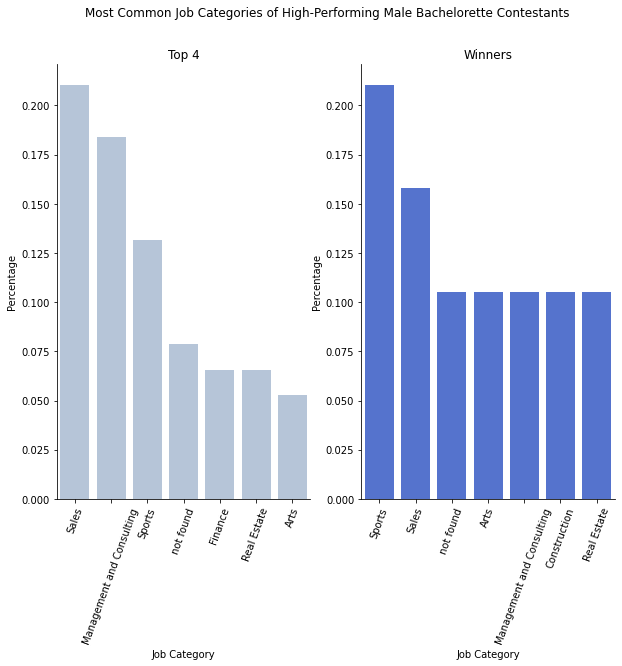

In [26]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,8))

order_top4_2 = norm_job_4_2['index'].iloc[:7]
order_winners_2 = norm_job_win2["index"].iloc[:7]

sns.barplot(x = norm_job_4_2["index"], y = norm_job_4_2["percentage"], color="lightsteelblue", ax = axes[0],
              order=order_top4_2).set(title="Top 4")
axes[0].set_xticklabels(order_top4_2, rotation = 70)
axes[0].set_xlabel('Job Category')
axes[0].set_ylabel('Percentage')

sns.barplot(x = norm_job_win2["index"], y = norm_job_win2["percentage"], color="royalblue", ax = axes[1],
              order=order_winners_2).set(title="Winners")
axes[1].set_xticklabels(order_winners_2, rotation = 70)
axes[1].set_xlabel('Job Category')
axes[1].set_ylabel('Percentage')

fig.suptitle('Most Common Job Categories of High-Performing Male Bachelorette Contestants')
sns.despine()

For the Top 4 subgroup, there was 76 men total. For the Winners, there were 19 men. This histogram plots the popularity of the job in comparision to the entire group.
For males, Sports and Sales are the most common job categories. We expected Sports to be a high-performing category, as the show's Bachelorettes may be interested in dating an athlete. However, we had not considered how popular Sales would be. 16 contestants who made top 4 had sales jobs! We are curious if this is simply because lots of men who appear on the Bachelorette work in sales, or if men who work in sales know how to "sell themselves" as an ideal partner to the Bachelorette and push themselves far on the show.

## Contestants by Home State

Another potential predictor variable we wanted to analyze is Home State of the contestants. 

First, we will normalize the categories for home state for Bachelor and Bachelorette contestants by comparing the frequency of state occurance to the whole of the subgroup for All, Top 4 and Winners.

In [27]:
#creating new df to normalize State Data for all subgroups for women on Bachelor

norm_state_all = contestants_df['State'].value_counts()
norm_state_all = norm_state_all.reset_index(name='count')
norm_state_all['Percentage'] = norm_state_all['count']/norm_state_all['count'].sum()
#print(norm_state_all)

norm_state_4 = top4_df['State'].value_counts()
norm_state_4 = norm_state_4.reset_index(name='count')
norm_state_4['Percentage'] = norm_state_4['count']/norm_state_4['count'].sum()
#print(norm_state_4)

norm_state_win = winners_df['State'].value_counts()
norm_state_win = norm_state_win.reset_index(name='count')
norm_state_win['Percentage'] = norm_state_win['count']/norm_state_win['count'].sum()
#print(norm_state_win)

In [28]:
#creating new df to normalize State Data for all subgroups for men on Bachelorette

norm_state_all_2 = contestants_df2['State'].value_counts()
norm_state_all_2 = norm_state_all_2.reset_index(name='count')
norm_state_all_2['Percentage'] = norm_state_all_2['count']/norm_state_all_2['count'].sum()
#print(norm_state_all)

norm_state_4_2 = top4_df2['State'].value_counts()
norm_state_4_2 = norm_state_4_2.reset_index(name='count')
norm_state_4_2['Percentage'] = norm_state_4_2['count']/norm_state_4_2['count'].sum()
#print(norm_state_4)

norm_state_win_2 = winners_df2['State'].value_counts()
norm_state_win_2 = norm_state_win_2.reset_index(name='count')
norm_state_win_2['Percentage'] = norm_state_win_2['count']/norm_state_win_2['count'].sum()
#print(norm_state_win)

Plot the categories of state for Bachelor contestants.

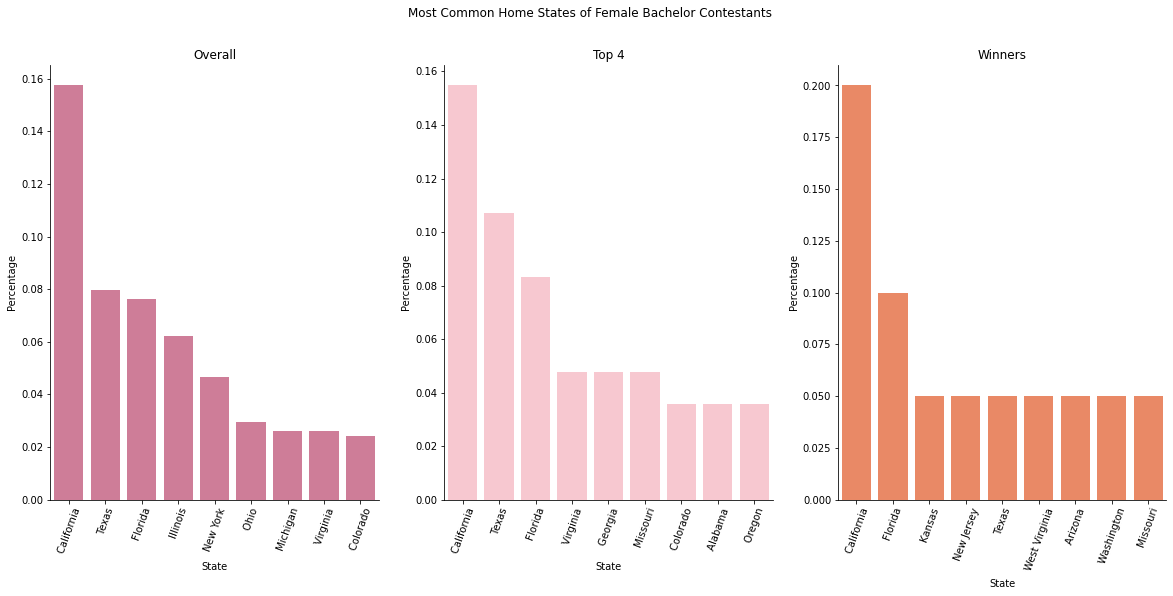

In [29]:
#Popular home states for Overall, Winners, and Top 4: The Bachelor
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,8))

order_overall = norm_state_all['index'].iloc[:9]
order_top4 = norm_state_4['index'].iloc[:9]
order_winners = norm_state_win['index'].iloc[:9]

sns.barplot(x = norm_state_all["index"], y = norm_state_all["Percentage"], color="palevioletred", ax = axes[0],
              order=order_overall).set(title="Overall")
axes[0].set_xticklabels(order_overall, rotation = 70)
axes[0].set_xlabel("State")

sns.barplot(x = norm_state_4["index"], y = norm_state_4["Percentage"], color="pink", ax = axes[1],
              order=order_top4).set(title="Top 4")
axes[1].set_xticklabels(order_top4, rotation = 70)
axes[1].set_xlabel("State")

sns.barplot(x = norm_state_win["index"], y = norm_state_win["Percentage"], color="coral", ax = axes[2],
              order=order_winners).set(title="Winners")
axes[2].set_xticklabels(order_winners, rotation = 70)
axes[2].set_xlabel("State")

fig.suptitle('Most Common Home States of Female Bachelor Contestants')
sns.despine()

Here we can see that many of the high performing contestants (Winners and Top 4) live in California and Florida. Many top 4 contestants also are from Texas. These three states are the most represented among all contestants, so this is not surprising. However, it is a bit interesting that Illinois and New York are the next two most popular states overall, and no winners have come from either of those two states (and only one person from both those states has even reached the top 4!).

Now, we will take a look at home state among contestants on the Bachelorette.

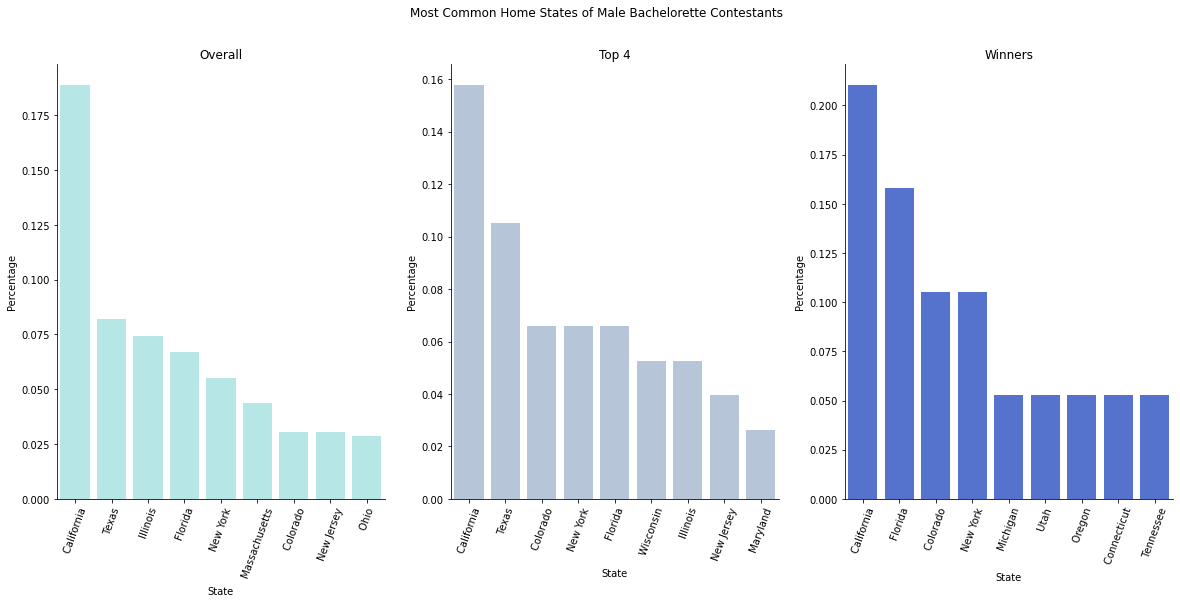

In [30]:
#Popular home states for Overall, Winners, and Top 4: The Bachelorette
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20,8))

order_overall2 = norm_state_all_2['index'].iloc[:9]
order_top4_2 = norm_state_4_2['index'].iloc[:9]
order_winners2 = norm_state_win_2['index'].iloc[:9]

sns.barplot(x = norm_state_all_2["index"], y = norm_state_all_2["Percentage"], color="paleturquoise", ax = axes[0],
              order=order_overall2).set(title="Overall")
axes[0].set_xticklabels(order_overall2, rotation = 70)
axes[0].set_xlabel("State")

sns.barplot(x = norm_state_4_2["index"], y = norm_state_4_2["Percentage"], color="lightsteelblue", ax = axes[1],
              order=order_top4_2).set(title="Top 4")
axes[1].set_xticklabels(order_top4_2, rotation = 70)
axes[1].set_xlabel("State")

sns.barplot(x = norm_state_win_2["index"], y = norm_state_win_2["Percentage"], color="royalblue", ax = axes[2],
              order=order_winners2).set(title="Winners")
axes[2].set_xticklabels(order_winners2, rotation = 70)
axes[2].set_xlabel("State")

fig.suptitle('Most Common Home States of Male Bachelorette Contestants')
sns.despine()

Similarly to the Bachelor, most Bachelorette contestants are from California, Texas, Illinois, Florida, and New York. After observing both the plots for the men and womens' home states, we observe that while Texans are one of the largest categories overall and in the Top 4, only one has actually won one of the shows before!

# Continued Analysis

**Driving Questions:**  
Do couples whose hometowns are a lower distance apart have a significantly higher chance of lasting after the show?

Is there a significant difference between the proportion of couples from the Bachelor versus Bachelorette who last at least one year?

What is the probability of winning/making top 4 if you are awarded the coveted "first impression rose"?  

# Analysis of Relationship Length

We are now curious how long the couples on the Bachelor and Bachelorette tend to last after the show finishes airing. We will create new dataframes representing each season, with data on the lead, his/her final choice, and how long they last. We will also investigate whether the distance between the lead and their final choice's hometown is correlated with how long the couple lasts.

(For seasons 13 and 22 of the Bachelor, where the Bachelor ended up breaking up with his final choice before the show finished airing and pursuing a relationship with the runner-up, we are going to use the data for the woman he chose to stay with, since these "switches" happened before the seasons finished airing.)

***Bachelor Couples***

First we make the Bachelors data frame.

In [31]:
bachelors_df = pd.DataFrame()
url = "https://en.wikipedia.org/wiki/The_Bachelor_(American_TV_series)"
table_class = "wikitable sortable jquery-tablesorter"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', {'class':"wikitable"})
bachelors_df = pd.read_html(str(table))
bachelors_df = pd.DataFrame(bachelors_df[0])
# keep cols for season, bachelor, winner, and relationship status
cols = ['Season', 'Bachelor', 'Winner', 'Still together?']
bachelors_df = bachelors_df[cols]

# some clean-up
# remove "[]" from hyperlinks
bachelors_df['Season'] = bachelors_df['Season'].apply(lambda x: x.split('[')[0] if '[' in x else x)
# table includes the season & bachelor twice if there were two runner-ups. remove the duplicates
bachelors_df.drop_duplicates(subset = ['Season'], keep = 'first', inplace = True) 

# in seasons 13 and 22, prior to the show finishing airing, the Bachelor chose to pursue
#  his runner up instead of the winner. change the winner category to instead have the woman
#  the bachelor ended up choosing. and adjust relationship status (both of these couples are still together!)
bachelors_df.loc[bachelors_df['Season'] == '13', 'Winner'] = 'Molly Malaney'
bachelors_df.loc[bachelors_df['Season'] == '22', 'Winner'] = 'Lauren Burnham'
bachelors_df.loc[bachelors_df['Season'].isin(['13', '22']), 'Still together?'] = 'Together with Runner-Up'

# change values of 'still together?'
bachelors_df.loc[bachelors_df['Still together?'] == 'No', 'Still together?'] = 'Broken Up'
bachelors_df.loc[bachelors_df['Still together?'] == 'Yes', 'Still together?'] = 'Together with Winner'

# remove most recent season (27) since it hasn't finished airing
bachelors_df.drop(bachelors_df.tail(1).index,inplace=True)

# add a column for relationship length
bachelors_df['Relationship Length in Years'] = [8/12, 3/12, 7/12,
                                          1/12, 1/12, 5,
                                          59/12, 1/12, 2/12,
                                          4/12, 0, 2/12,
                                          14, 3/12, 3/12,
                                          7/12, 11, 7/12,
                                          2/12, 14/12, 5/12,
                                          5, 14/12, 0,
                                          2, 6/12]

This barplot displays the relationship lengths of Bachelor couples, colored by relationship status. We can see that only four couples are still together. The median relationship length is less than half a year. Interestingly, both couples who chose to go back on their choice and pursue the runner-up are still together.

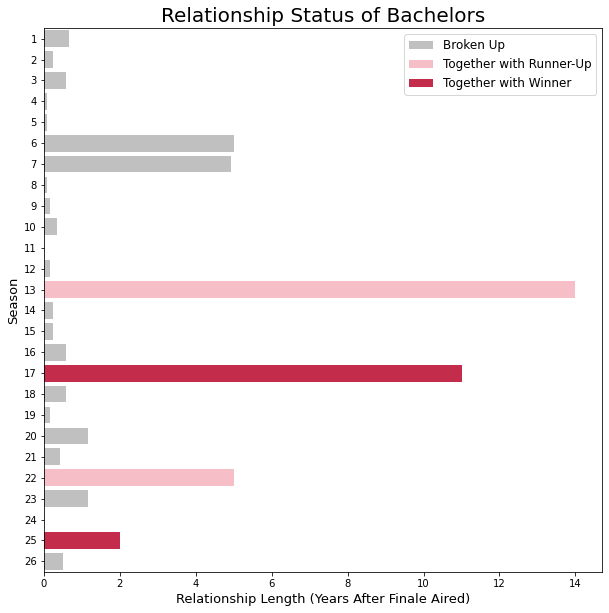

In [32]:
colors = {'Broken Up': 'silver', 
          'Together with Runner-Up': 'lightpink', 
          'Together with Winner': 'crimson'}

plt.figure(figsize = (10,10))
height = 0.9

plt.title('Relationship Status of Bachelors', fontsize = 20)

sns.barplot(y = bachelors_df['Season'].apply(str), x = bachelors_df['Relationship Length in Years'],
         hue = bachelors_df['Still together?'], palette = colors, dodge = False)

plt.legend(loc = 'upper right', fontsize = 12)
plt.ylabel('Season', fontsize = 13)
plt.xlabel('Relationship Length (Years After Finale Aired)', fontsize = 13)

plt.show()

In [33]:
np.median(bachelors_df['Relationship Length in Years'])

0.45833333333333337

We will now perform some joins in order to get some of the Bachelor's hometowns. Since about half of these Bachelors (at least in the more recent seasons) were once contestants on the Bachelorette, we can get their hometowns from the contestants_df2 table. For the rest of them, we will manually enter their hometowns.

In [34]:
bachelors_df = bachelors_df.merge(contestants_df2[['Name', 'Town', 'State']], left_on = 'Bachelor', right_on = 'Name', how = 'left')

In [35]:
bachelors_df.loc[bachelors_df['Season'] == '1', ['Town', 'State']] = ['Charlottesville', 'Virginia']
bachelors_df.loc[bachelors_df['Season'] == '2', ['Town', 'State']] = ['Butler', 'Missouri']
bachelors_df.loc[bachelors_df['Season'] == '3', ['Town', 'State']] = ['Santa Barbara', 'California']
bachelors_df.loc[bachelors_df['Season'] == '5', ['Town', 'State']] = ['Nepean', 'Ontario']
bachelors_df.loc[bachelors_df['Season'] == '6', ['Town', 'State']] = ['Downey', 'California']
bachelors_df.loc[bachelors_df['Season'] == '7', ['Town', 'State']] = ['New York City', 'New York']
bachelors_df.loc[bachelors_df['Season'] == '8', ['Town', 'State']] = ['Fort Collins', 'Colorado']
bachelors_df.loc[bachelors_df['Season'] == '9', ['Town', 'State']] = ['Milan', 'Italy']
bachelors_df.loc[bachelors_df['Season'] == '10', ['Town', 'State']] = ['Lancaster', 'Pennsylvania']
bachelors_df.loc[bachelors_df['Season'] == '11', ['Town', 'State']] = ['Livingston', 'Texas']
bachelors_df.loc[bachelors_df['Season'] == '12', ['Town', 'State']] = ['London', 'United Kingdom']
bachelors_df.loc[bachelors_df['Season'] == '14', ['Town', 'State']] = ['Dallas', 'Texas']
bachelors_df.loc[bachelors_df['Season'] == '15', ['Town', 'State']] = ['Livingston', 'Texas']
bachelors_df.loc[bachelors_df['Season'] == '25', ['Town', 'State']] = ['New York City', 'New York']
bachelors_df['Season'] = pd.to_numeric(bachelors_df['Season'])

bachelors_df.drop(['Name'], axis = 1, inplace = True)
bachelors_df.drop_duplicates(subset = ['Season'], keep = 'first', inplace = True) 
# rename town and state for bachelors
bachelors_df = bachelors_df.rename(columns={"Town": "Lead Town", "State": "Lead State"})

Now, we will merge with the winners_df to get each winning woman's town and state! We only need to manually add the ones though for seasons 3-4 and 6-8, which didn't have contestant data on Wikipedia when we did our initial scraping.

In [36]:
bachelors_df = bachelors_df.merge(winners_df[['Season', 'Name', 'Town', 'State']], right_on = 'Season', left_on = 'Season', how = 'left')
bachelors_df.drop(['Name'], axis = 1, inplace = True)
bachelors_df.loc[bachelors_df['Season'] == 3, ['Town', 'State']] = ['Mentor', 'Ohio']
bachelors_df.loc[bachelors_df['Season'] == 4, ['Town', 'State']] = ['Beverly Hills', 'California']
bachelors_df.loc[bachelors_df['Season'] == 6, ['Town', 'State']] = ['Tampa', 'Florida']
bachelors_df.loc[bachelors_df['Season'] == 7, ['Town', 'State']] = ['McKinney', 'Texas']
bachelors_df.loc[bachelors_df['Season'] == 8, ['Town', 'State']] = ['Nashville', 'Tennessee']

bachelors_df = bachelors_df.rename(columns={"Town": "Winner Town", "State": "Winner State"})

In [37]:
bachelors_df.head()

,Season,Bachelor,Winner,Still together?,Relationship Length in Years,Lead Town,Lead State,Winner Town,Winner State
0,1,Alex Michel,Amanda Marsh,Broken Up,0.666667,Charlottesville,Virginia,Chanute,Kansas
1,2,Aaron Buerge,Helene Eksterowicz,Broken Up,0.250000,Butler,Missouri,Gloucester,New Jersey
2,3,Andrew Firestone,Jen Schefft,Broken Up,0.583333,Santa Barbara,California,Mentor,Ohio
3,4,Bob Guiney,Estella Gardinier,Broken Up,0.083333,Ferndale,Michigan,Beverly Hills,California
4,5,Jesse Palmer,Jessica Bowlin,Broken Up,0.083333,Nepean,Ontario,Huntington Beach,California


***Special call out that the current Bachelor Franchise host, Jesse Palmer, was only with his match for .08 years after the show aired. That is about 1 month!!***

Next we need to use an API to obtain the latitude and longitude for both members of the couples hometowns, then compute the distance between the two locations.

In [38]:
# combine town and state into one column, for both leads and winners
bachelors_df['Lead Location'] = bachelors_df['Lead Town'] + ', ' + bachelors_df['Lead State']
bachelors_df['Winner Location'] = bachelors_df['Winner Town'] + ', ' + bachelors_df['Winner State']

# use Nominatim to obtain latitude and longitude for lead's and winner's hometown. This is a free service
locator = Nominatim(user_agent="email@gmail.com", timeout=5)
bachelors_df['Lead Lat Long'] = bachelors_df['Lead Location'].apply(lambda x: locator.geocode(x)).apply(lambda x: (x.latitude, x.longitude))
bachelors_df['Winner Lat Long'] = bachelors_df['Winner Location'].apply(lambda x: locator.geocode(x)).apply(lambda x: (x.latitude, x.longitude))

# calculate distance
bachelors_df['Distance'] = bachelors_df.apply(lambda x: distance.distance(x['Lead Lat Long'], x['Winner Lat Long']), axis=1)
bachelors_df['Distance'] = bachelors_df['Distance'].astype(str).str[:-3].astype(float)

Because the relationship lengths have a positive skew, we will log-transform relationship length before computing the correlation with distance between hometowns. We suspect there will be a negative correlation between distance and relationship length.

In [39]:
bachelors_df['Log Relationship'] = np.log(bachelors_df['Relationship Length in Years'] + 1)

pearsonr(bachelors_df['Log Relationship'], bachelors_df['Distance'])

PearsonRResult(statistic=-0.19841544176361303, pvalue=0.33121322519457463)

For contestants from the Bachelor, there is a minimal correlation of -.2 between relationship length and distance between hometowns. The p-value associated is 0.33. But we will still perform the same procedure for Bachelorettes and their winners.

***Bachelorette Couples***

Let's make the Bachelorettes dataframe:

In [40]:
bachelorettes_df = pd.DataFrame()
url = "https://en.wikipedia.org/wiki/The_Bachelorette_(American_TV_series)"
table_class = "wikitable sortable jquery-tablesorter"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', {'class':"wikitable"})
bachelorettes_df = pd.read_html(str(table))
bachelorettes_df = pd.DataFrame(bachelorettes_df[0])
# keep cols for season, bachelor, winner, and relationship status
cols = ['Season', 'Bachelorette', 'Winner', 'Still together?']
bachelorettes_df = bachelorettes_df[cols]

# some clean-up
# remove "[]" from hyperlinks
bachelorettes_df['Season'] = bachelorettes_df['Season'].apply(lambda x: x.split('[')[0] if '[' in x else x)

# change values of 'still together?'
bachelorettes_df.loc[bachelorettes_df['Still together?'] == 'No', 'Still together?'] = 'Broken Up'
bachelorettes_df.loc[bachelorettes_df['Still together?'] == 'Yes', 'Still together?'] = 'Together with Winner'

bachelorettes_df['Relationship Length in Years'] = [13, 1, 0,
                                                  4/12, 1, 15/12,
                                                  9, 3/12, 9.5,
                                                  5/12, 39/12, 7.5,
                                                  6.5, 2, 0,
                                                  9/12, 11/12, 3/12,
                                                  6/12, 1/12, 0]

# change season names for seasons where there were two bachelorettes
bachelorettes_df.loc[bachelorettes_df['Bachelorette'] == 'Clare Crawley', 'Season'] = '16a'
bachelorettes_df.loc[bachelorettes_df['Bachelorette'] == 'Tayshia Adams', 'Season'] = '16b'
bachelorettes_df.loc[bachelorettes_df['Bachelorette'] == 'Gabby Windey', 'Season'] = '19a'
bachelorettes_df.loc[bachelorettes_df['Bachelorette'] == 'Rachel Recchia', 'Season'] = '19b'

We will create a similar visualization as we did previously of relationship lengths of couples, but this time for the Bachelorette. Four couples are still together. The median relationship length is about 10 months, which is a little longer than for couples on the Bachelor.

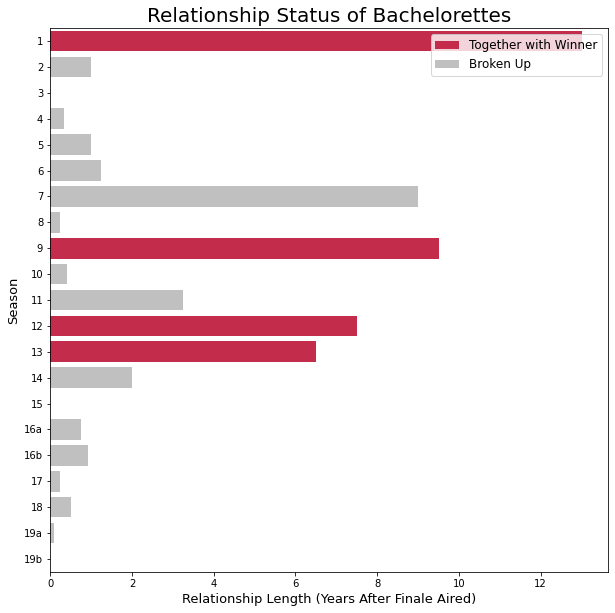

In [41]:
colors = {'Broken Up': 'silver', 
          'Together with Runner-Up': 'lightpink', 
          'Together with Winner': 'crimson'}

plt.figure(figsize = (10,10))
height = 0.9

plt.title('Relationship Status of Bachelorettes', fontsize = 20)

sns.barplot(y = bachelorettes_df['Season'].apply(str), x = bachelorettes_df['Relationship Length in Years'],
         hue = bachelorettes_df['Still together?'], palette = colors, dodge = False)

plt.legend(loc = 'upper right', fontsize = 12)
plt.ylabel('Season', fontsize = 13)
plt.xlabel('Relationship Length (Years After Finale Aired)', fontsize = 13)

plt.show()

In [42]:
np.median(bachelorettes_df['Relationship Length in Years'])

0.9166666666666666

Now, we proceed with getting the distances between lead and winners' hometowns. Use a join with the contestants on the Bachelor contestants table, contestants_df, to get these Bachelorette's hometown and state. Only three need to be manually added.

In [43]:
bachelorettes_df = bachelorettes_df.merge(contestants_df[['Name', 'Town', 'State']], left_on = 'Bachelorette', right_on = 'Name', how = 'left')
bachelorettes_df.drop(['Name'], axis = 1, inplace = True)
bachelorettes_df.loc[bachelorettes_df['Season'] == '2', ['Town', 'State']] = ['Beaverton', 'Oregon']
bachelorettes_df.loc[bachelorettes_df['Season'] == '3', ['Town', 'State']] = ['Mentor', 'Ohio']
bachelorettes_df.loc[bachelorettes_df['Bachelorette'] == 'Gabby Windey', ['Town', 'State']] = ['Denver', 'Colorado']
bachelors_df['Season'] = pd.to_numeric(bachelors_df['Season'])

# rename town and state for bachelors
bachelorettes_df = bachelorettes_df.rename(columns={"Town": "Lead Town", "State": "Lead State"})

Now merge again with contestants_df2, which contains Bachelorette contestant data, to get as many of the male winners' hometowns as possible.

In [44]:
bachelorettes_df = bachelorettes_df.merge(contestants_df2[['Name', 'Town', 'State']], left_on = 'Winner', right_on = 'Name', how = 'left')
bachelorettes_df.drop(['Name'], axis = 1, inplace = True)
bachelorettes_df.loc[bachelorettes_df['Season'] == 2, ['Town', 'State']] = ['New York', 'New York']
bachelorettes_df.loc[bachelorettes_df['Season'] == 5, ['Town', 'State']] = ['Monroe', 'Michigan']
bachelorettes_df.loc[bachelorettes_df['Season'] == 7, ['Town', 'State']] = ['Roslyn', 'New York']
bachelorettes_df.loc[bachelorettes_df['Season'] == 8, ['Town', 'State']] = ['St. George', 'Utah']
bachelorettes_df.loc[bachelorettes_df['Season'] == 15, ['Town', 'State']] = ['Sevierville', 'Tennessee']
# rename town and state for winners
bachelorettes_df = bachelorettes_df.rename(columns={"Town": "Winner Town", "State": "Winner State"})


In [45]:
bachelorettes_df.head()

,Season,Bachelorette,Winner,Still together?,Relationship Length in Years,Lead Town,Lead State,Winner Town,Winner State
0,1,Trista Rehn,Ryan Sutter,Together with Winner,13.000000,St. Louis,Missouri,Vail,Colorado
1,2,Meredith Phillips,Ian Mckee,Broken Up,1.000000,Beaverton,Oregon,NaN,NaN
2,3,Jen Schefft,Jerry Ferris,Broken Up,0.000000,Mentor,Ohio,Los Angeles,California
3,4,DeAnna Pappas,Jesse Csincsak,Broken Up,0.333333,Newnan,Georgia,Breckenridge,Colorado
4,5,Jillian Harris,Ed Swiderski,Broken Up,1.000000,Peace River,Alberta,NaN,NaN


In [46]:
# combine town and state into one column, for both leads and winners
bachelorettes_df['Lead Location'] = bachelorettes_df['Lead Town'] + ', ' + bachelorettes_df['Lead State']
bachelorettes_df['Winner Location'] = bachelorettes_df['Winner Town'] + ', ' + bachelorettes_df['Winner State']

# use Nominatim to obtain latitude and longitude for lead's and winner's hometown. This is a free service
locator = Nominatim(user_agent="email@gmail.com", timeout=5)
bachelorettes_df['Lead Lat Long'] = bachelorettes_df['Lead Location'].apply(lambda x: locator.geocode(x)).apply(lambda x: (x.latitude, x.longitude))
bachelorettes_df['Winner Lat Long'] = bachelorettes_df['Winner Location'].apply(lambda x: locator.geocode(x)).apply(lambda x: (x.latitude, x.longitude))

# calculate distance
bachelorettes_df['Distance'] = bachelorettes_df.apply(lambda x: distance.distance(x['Lead Lat Long'], x['Winner Lat Long']), axis=1)
bachelorettes_df['Distance'] = bachelorettes_df['Distance'].astype(str).str[:-3].astype(float)

In [47]:
bachelorettes_df['Log Relationship'] = np.log(bachelorettes_df['Relationship Length in Years'] + 1)

pearsonr(bachelorettes_df['Log Relationship'], bachelorettes_df['Distance'])

PearsonRResult(statistic=-0.22143017590420297, pvalue=0.32200804764190655)

The correlation between relationship length and distance is about the same for couples from the Bachelorette as Bachelor couples. So, it is also not a statistically significant relationship.

#Test of Significance: Relationship Length

***Is the proportion of couples from the two franchises who lasted at least a year significantly different?***

Is there evidence that the Bachelors make better decisions than the Bachelorettes, or vice versa? We will see if there is a significant difference in the proportion of Bachelor and Bachelorette couples which last longer than one year after the show.

In [48]:
# indicate whether relationship lasted at least a year
bachelorettes_df['At Least One Year'] = bachelorettes_df['Relationship Length in Years'].apply(lambda x: 1 if x >= 1 else 0)
bachelors_df['At Least One Year'] = bachelors_df['Relationship Length in Years'].apply(lambda x: 1 if x >= 1 else 0)

In [49]:
n_together_after_1_year = np.array([np.sum(bachelorettes_df['At Least One Year']),
np.sum(bachelors_df['At Least One Year'])])
n_rows = np.array([len(bachelorettes_df),
                   len(bachelors_df)])
z_score, p_value = proportions_ztest(count = n_together_after_1_year, nobs = n_rows)
print('Z-score:', z_score, 'P-value:', p_value)

Z-score: 1.0471406288094718 P-value: 0.2950347231665088


With a p-value of 0.295, we do not have significant evidence to conclude that couples from one franchise are more successful in terms of lasting at least one year after the show airs.

# First Impression Roses

How important is a first impression in Bachelor Nation? Our final question concerns how much the coveted "first impression rose" can influence contestant success. This rose is given on night one to the contestant who makes the best first impression on the lead. Does winning this special rose give you a higher probability of winning? Does it at least improve your probability of making it to the top 4?

To investigate this question, we will use scrape data from the Bachelor Nation Wiki containing information on eliminations and roses in each episode. We were able to do this for Bachelor seasons 10-16 and 18-22.

In [50]:
seasons = np.arange(10, 23)
# don't include s17 since there were multiple first impression roses
seasons = seasons[seasons != 17]
roses_df = pd.DataFrame()
urlstart = 'https://bachelor-nation.fandom.com/wiki/The_Bachelor_(Season_'

def FIR_scrape(seasons, roses_df, urlstart):
  for i in range(0, len(seasons)):
    # write the url for specific season
    url = urlstart + str(seasons[i]) + ')#Call-Out_Order'
    table_class = "wikitable sortable jquery-tablesorter"
    response = requests.get(url)
    # parse data from html
    soup = BeautifulSoup(response.text, 'html.parser')
    callout_table = soup.find('table', {'class':"wikitable"})
    df = pd.read_html(str(callout_table))
    # convert list to data frame
    df = pd.DataFrame(df[0])
    # fix multiindex
    if seasons[i] <= 22:
      df.columns = df.columns.droplevel(0)
    # get first row of the data. FIR winner will be listed first in column 1
    roses = df.head(1)
    roses_df = roses_df.append(roses, ignore_index = True)
  d = {'FIR': roses_df['1'], 'Season': seasons}
  roses_df = pd.DataFrame(data = d)
  return roses_df


In [51]:
roses_df = FIR_scrape(seasons, roses_df, urlstart)
roses_df.head()

,FIR,Season
0,Stephanie T.,10
1,Jenni,11
2,Amanda R.,12
3,Nikki,13
4,Tenley,14


Because the roses data frame does not use the same conventions for using the women's last initial or full last name in the name column, we will change the name column to only be the first name.

In [52]:
winners_df.loc[:,'Name'] = winners_df['Name'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
top4_df.loc[:,'Name'] = top4_df['Name'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
roses_df.loc[:,'FIR'] = roses_df['FIR'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)

/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Now, merge the FIR data with the winners data frame and the top 4 data frame on season.

In [53]:
FIR_merge_winners = roses_df.merge(winners_df, on = 'Season')
FIR_merge_top4 = roses_df.merge(top4_df, on = 'Season')

In [54]:
# in how many seasons was the FIR the overall winner?
FIR_merge_winners[FIR_merge_winners['FIR'] == FIR_merge_winners['Name']]

,FIR,Season,Name,Age,Town,State,Occupation,Outcome,Job Category


In [55]:
# in how many seasons did the FIR make top 4?
FIR_merge_top4[FIR_merge_top4['FIR'] == FIR_merge_top4['Name']]

,FIR,Season,Name,Age,Town,State,Occupation,Outcome,Job Category
5,Jenni,11,Jenni,27.0,Wichita,Kansas,Phoenix Suns Cheerleader,Co-runners-up,Dance
10,Amanda,12,Amanda,27.0,Niceville,Florida,Account Executive,Week 7,Sales
17,Tenley,14,Tenley,25.0,Newberg,Oregon,College Admissions,Runner-Up,not found
22,Ashley,15,Ashley,26.0,Madawaska,Maine,Dental Student,Week 9,Dental Care
25,Lindzi,16,Lindzi,27.0,Ocala,Florida,Business Development Manager,Runner-up,Management and Consulting
42,Rachel,21,Rachel,31.0,Dallas,Texas,Attorney,Week 9,Legal


It appears that among the 12 Bachelor seasons we observed, where we were able to scrape this data regarding roses from the fan wiki, 50% of first impression rose winners made top 4! None of them, however, won the show. While we may not have evidence that this highly sought after rose enhances your chances of winning, contestants can have some confidence that it might mean they'll be sticking around for a while.

***Bachelorette***

We then perform the same process for the Bachelorette, seasons 5-8, 10, 11, 13-14, and 15, and 17-18. These are seasons where only one FIR was given.

In [57]:
seasons = np.array([i for i in range(5,19) if i not in [9, 12, 14, 16]])
urlstart = 'https://bachelor-nation.fandom.com/wiki/The_Bachelorette_(Season_'
roses_df2 = pd.DataFrame()

def FIR_scrape(seasons, roses_df, urlstart):
  for i in range(0, len(seasons)):
    # write the url for specific season
    if seasons[i] <= 14:
      url = urlstart + str(seasons[i]) + ')#Call-Out_Order'
      #print(url)
    else:
      url = urlstart + str(seasons[i]) + ')#Call-out_order'
    table_class = "wikitable sortable jquery-tablesorter"
    response = requests.get(url)
    # parse data from html
    soup = BeautifulSoup(response.text, 'html.parser')
    callout_table = soup.find('table', {'class':"wikitable"})
    df = pd.read_html(str(callout_table))
    # convert list to data frame
    df = pd.DataFrame(df[0])
    # fix multiindex
    df.columns = df.columns.droplevel(0)
    # get first row of the data. FIR winner will be listed first in column 1
    roses = df.head(1)
    roses_df = roses_df.append(roses, ignore_index = True)
  d = {'FIR': roses_df['1'], 'Season': seasons}
  roses_df = pd.DataFrame(data = d)
  return roses_df

In [58]:
roses_df2 = FIR_scrape(seasons, roses_df2, urlstart)
roses_df2.head()

,FIR,Season
0,David,5
1,Roberto,6
2,Ryan P.,7
3,Doug,8
4,Nick V.,10


In [60]:
winners_df2.loc[:,'Name'] = winners_df2['Name'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
top4_df2.loc[:,'Name'] = top4_df2['Name'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
roses_df2.loc[:,'FIR'] = roses_df2['FIR'].apply(lambda x: x.split(' ')[0])

/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [61]:
FIR_merge_winners2 = roses_df2.merge(winners_df2, on = 'Season')
FIR_merge_top4_2 = roses_df2.merge(top4_df2, on = 'Season')

In [62]:
# in how many seasons was the FIR the overall winner?
FIR_merge_winners2[FIR_merge_winners2['FIR'] == FIR_merge_winners2['Name']]

,FIR,Season,Name,Age,Town,State,Occupation,Outcome,Job Category
1,Roberto,6,Roberto,26,Tampa,Florida,Insurance Agent,Winner,Sales
5,Shawn,11,Shawn,28,Windsor Locks,Connecticut,Personal Trainer,Winner,Sports
6,Bryan,13,Bryan,37,Miami,Florida,Chiropractor,Winner,Medical
9,Nayte,18,Nayte,27,Winnipeg,Manitoba,Sales Executive,Winner,Sales


In [63]:
# in how many seasons did the FIR make top 4?
FIR_merge_top4_2[FIR_merge_top4_2['FIR'] == FIR_merge_top4_2['Name']]

,FIR,Season,Name,Age,Town,State,Occupation,Outcome,Job Category
4,Roberto,6,Roberto,26,Tampa,Florida,Insurance Agent,Winner,Sales
17,Nick,10,Nick,33,Waukesha,Wisconsin,Software Sales Executive,Runner-up,Sales
20,Shawn,11,Shawn,28,Windsor Locks,Connecticut,Personal Trainer,Winner,Sports
24,Bryan,13,Bryan,37,Miami,Florida,Chiropractor,Winner,Medical
34,Greg,17,Greg,27,Edison,New Jersey,Marketing Sales Representative,Week 7,Marketing
36,Nayte,18,Nayte,27,Winnipeg,Manitoba,Sales Executive,Winner,Sales


For the Bachelorette, we were able to scrape First Impression Rose recipient data for 10 seasons. Of those 10 seasons, the FIR recipient ended up being the winner of his season 4 times! This leads us to believe that the FIR recipient will have a better success likelihood than other contestants.

In [64]:
FIR_Top4_Men = FIR_merge_top4_2[FIR_merge_top4_2['FIR'] == FIR_merge_top4_2['Name']]
FIR_Top4_Women = FIR_merge_top4[FIR_merge_top4['FIR'] == FIR_merge_top4['Name']]

#Test of Significance: FIR

***Is the proportion of FIR recipients who made it to the Top 4 of the show from the two franchises significantly different?***

In [65]:
#significance test for FIR recipients who made the top 4
prop_top4_recieved_FIR = np.array([len(FIR_Top4_Men['FIR']),
len(FIR_Top4_Women['FIR'])])
n_rows = np.array([len(roses_df),
                   len(roses_df2)])
z_score, p_value = proportions_ztest(count = prop_top4_recieved_FIR, nobs = n_rows)
print('Z-score:', z_score, 'P-value:', p_value)

Z-score: -0.4690415759823428 P-value: 0.639039918371475


With a p-value of 0.64, we do not have significant evidence to conclude that the proportion FIR recipients who made it to the Top 4 of the show are significantly different between the two franchises.

#Conclusion  
With our part 2 driving question being whether or not there was a significant difference between the proportion of couples from the Bachelor versus Bachelorette who last at least one year- we cannot conclude that our results from the Relationship Length section of our analysis were significant.

As for the First Impression Rose Analysis, we were interested in the probability of winning/making top 4 if you are awarded the coveted "first impression rose". Here, while it appears that the men on the Bachelorette tend to perform well when award the FIR rose, statistically we cannot conclude that there is a difference in proportion of FIR in the Top 4 performers between the 2 franchises. 